## Cell Model Training

Primary notebook for cell counting efforts that involves 3 primary steps:

1. Select training, validation and un-annotated data
2. Train model and freeze weights in persisted location
3. Load model and apply to un-annotated data

In [1]:
import os
import os.path as osp
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrcnn import visualize as mrcnn_viz
from mrcnn import model as mrcnn_model_lib
from imgaug import augmenters as iaa
from cvutils.rectlabel import io as rectlabel_io
from cvutils.mrcnn import model as mrcnn_model
from cvutils.mrcnn.session import init_keras_session
from celldom.dataset import cell_dataset
from celldom.dataset import utils as dataset_utils
from celldom.config import cell_config
from celldom.warnings import disable_mrcnn_warnings
from celldom import seed
init_keras_session()
disable_mrcnn_warnings()

data_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03', 'ApartmentTraining')
model_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.3', 'cell_model')
model_path = osp.join(model_dir, 'cell_model.h5')
export_dir = 'results'

# Initialize output directories
os.makedirs(export_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

Using TensorFlow backend.


## Data Partitioning

The purpose of this section is to establish training, validation, and external partitions of the configured dataset.  Generally, all annotated data up to a specific portion of the dataset will be used for training or validation and any non-annotated images or images w/ bad or inconsistent annotations will become "external" (i.e. used only for applications of the model):

In [2]:
# Determine all available images for training
data_files = dataset_utils.get_data_files(data_dir, patterns=['*.jpeg'])

# Attach identities file (gives st + apt numbers and some other already processed metadata)
data_files_meta = pd.read_csv(osp.join(data_dir, 'analysis', 'identities.csv'), dtype={'st_num': str, 'apt_num': str})
meta_cols = ['st_num', 'apt_num', 'cohort', 'date', 'z', 'image_name']
data_files_meta = data_files_meta[meta_cols]

n_before = len(data_files)
data_files = pd.merge(
    data_files, 
    data_files_meta,
    on='image_name',
    how='left'
)
assert data_files[meta_cols].notnull().all().all()
assert n_before == len(data_files)

# Ensure there are no duplicate image entries
if len(data_files) > 0:
    assert data_files['image_name'].value_counts().max() == 1

print(
    'Number of images total = {}, number annotated = {}'
    .format(len(data_files), data_files.annot_exists.sum())
)
data_files.head(3)

Number of images total = 6092, number annotated = 680


,image_name,image_path,annot_path,annot_exists,st_num,apt_num,cohort,date,z
0,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,009,022,1nMQuiz,201805311723,z_0
1,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,009,022,1nMQuiz,201805311723,zm3
2,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,009,022,1nMQuiz,201805311723,zm6


In [3]:
# Compute summary statistics about images to help determine the status of each
data_files = cell_dataset.quantify_data_files(data_files, cell_config.CLASS_NAMES)
data_files[data_files.annot_exists].head()

,annot_exists,annot_path,apt_num,cohort,ct:cell,date,image_name,image_path,st_num,z
0,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,022,1nMQuiz,1.0,201805311723,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,009,z_0
1,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,022,1nMQuiz,1.0,201805311723,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,009,zm3
2,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,022,1nMQuiz,1.0,201805311723,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,009,zm6
3,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,022,1nMQuiz,1.0,201805311723,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,009,zm9
4,True,/lab/data/celldom/dataset/dataset03/ApartmentT...,022,1nMQuiz,1.0,201805311723,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,009,zp3


In [4]:
data_files['ct:cell'].describe()

count    680.000000
mean       6.176471
std        9.184480
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       70.000000
Name: ct:cell, dtype: float64

In [5]:
def get_exclusion_reason(r):
    if not r['annot_exists']:
        return 'No Annotations'
    # Currently, there are no other reasons to explicitly exclude certain annotations
    # (but keep this step in case that becomes true)
    return None

data_files['exclusion'] = data_files.apply(get_exclusion_reason, axis=1)
data_files[data_files.exclusion.notnull() & data_files.annot_exists].head()

,annot_exists,annot_path,apt_num,cohort,ct:cell,date,image_name,image_path,st_num,z,exclusion


In [6]:
data_files.exclusion.isnull().value_counts()

False    5412
True      680
Name: exclusion, dtype: int64

In [7]:
data_files.exclusion.value_counts()

No Annotations    5412
Name: exclusion, dtype: int64

In [8]:
MODELING_MAX_SAMPLES = len(data_files)
TRAINING_FRACTION = .8

# Determine index corresponding to first MODELING_MAX_SAMPLES records eligible for model (as training or validation records)
idx_modeling = data_files[data_files.exclusion.isnull()].head(MODELING_MAX_SAMPLES).index.values

# Split index into training and validation 
idx_train = pd.Series(idx_modeling).sample(frac=TRAINING_FRACTION, random_state=seed).values
idx_val = np.setdiff1d(idx_modeling, idx_train)

data_files['group'] = 'external'
data_files.loc[idx_train, 'group'] = 'training'
data_files.loc[idx_val, 'group'] = 'validation'

# Summarize and verify counts by training record group
grp_ct = data_files['group'].value_counts()
assert grp_ct['training'] + grp_ct['validation'] == data_files.exclusion.isnull().sum()
assert grp_ct['external'] == data_files.exclusion.notnull().sum()
data_files['group'].value_counts()

external      5412
training       544
validation     136
Name: group, dtype: int64

In [11]:
#'{address}-{cohort}-{ry:02d}-{rx:02d}-{date}-{z}-{my:04d}-{mx:04d}-{patch_idx:02d}.jpeg'
#data_files['image_name'].iloc[0]

In [9]:
data_files.groupby('group')['ct:cell'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
external,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
training,544.0,6.174632,8.924113,1.0,3.0,4.0,5.0,70.0
validation,136.0,6.183824,10.195280,1.0,3.0,4.0,5.0,70.0


In [10]:
# Save record of data file categorization for later reference
path = osp.join(export_dir, 'data_files.csv')
data_files.to_csv(path, index=False)
'Data file metadata saved to path {}'.format(path)

'Data file metadata saved to path results/data_files.csv'

## Training

Based on the file categorization above, this section will use all available training + validation data to build a segmentation model:

In [11]:
# Training dataset
train_image_paths = data_files.groupby('group').get_group('training')['image_path'].values
dataset_train = cell_dataset.CellDataset()
dataset_train.initialize(train_image_paths)
dataset_train.prepare()

# # Validation dataset
val_image_paths = data_files.groupby('group').get_group('validation')['image_path'].values
dataset_val = cell_dataset.CellDataset()
dataset_val.initialize(val_image_paths)
dataset_val.prepare()

'Num training images = {}, num validation images = {}'.format(len(train_image_paths), len(val_image_paths))

'Num training images = 544, num validation images = 136'

In [12]:
# Fetch RCNN training configuration
train_config = cell_config.CellTrainingConfig()

# # Set these step counts to equal data size so that a single epoch is easier to describe
# train_config.STEPS_PER_EPOCH = len(train_image_paths)
# train_config.VALIDATION_STEPS = len(val_image_paths)

train_config.STEPS_PER_EPOCH = 100
train_config.VALIDATION_STEPS = 50
    
train_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        250
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [214]:
# Define train-time augmentation
augmentation = iaa.Sequential([
    iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.CropAndPad((0, 5)),
        iaa.Multiply((0.8, 1.2)),
        iaa.ContrastNormalization((0.5, 2.0)),
        iaa.GaussianBlur(sigma=(0.0, 2.0))
    ]),
    iaa.Sometimes(0.9, iaa.Affine(
        rotate=(-10, 10),
        scale=(.9, 1.1)
    ))
])

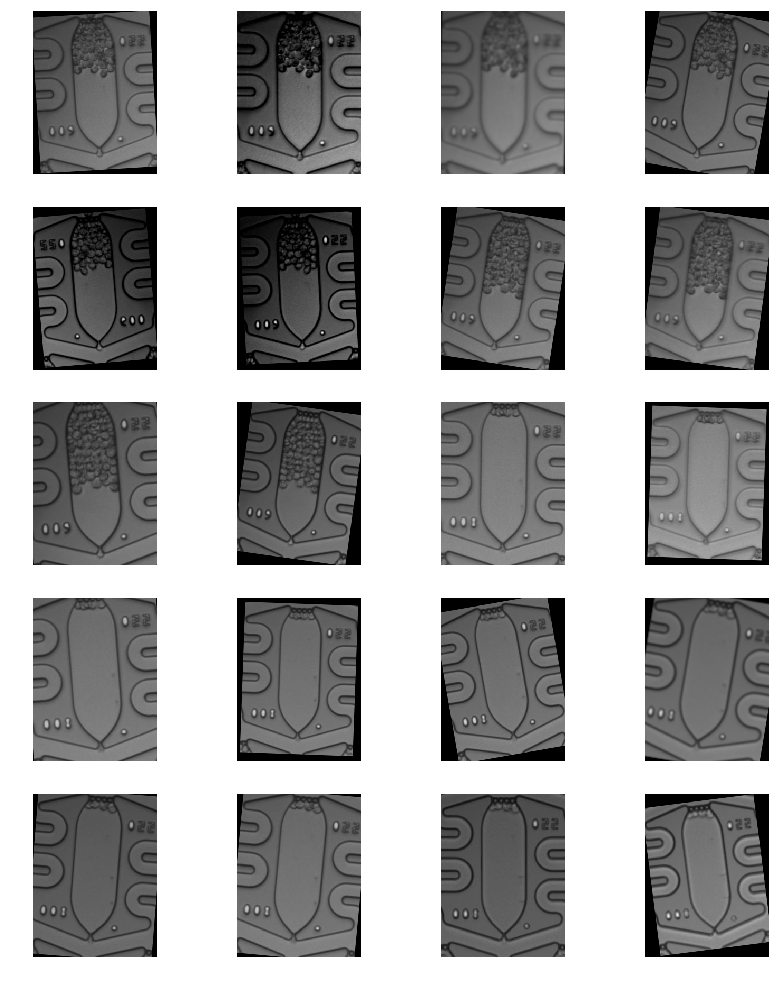

In [215]:
# Show example augmentations
mrcnn_viz.display_images([
    augmentation.augment_image(dataset_train.load_image(i))
    for i in range(470, 490)
])

In [14]:
# Initialize model from COCO weights (change to "last" to restart from last training run)
model = mrcnn_model.get_model(
    mode="training", config=train_config, 
    model_dir=model_dir, init_with='coco'
)

In [219]:
# Run training for small number of epochs (takes about 1 min per epoch on this dataset)
n_epochs = 100
model.train(
    dataset_train, dataset_val, 
    learning_rate=train_config.LEARNING_RATE, 
    epochs=n_epochs, 
    layers='heads',
    augmentation=augmentation
)


Starting at epoch 75. LR=0.001

Checkpoint Path: /lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (T

In [221]:
# Fine tune rest of network
n_epochs = 200
model.train(
    dataset_train, dataset_val, 
    learning_rate=train_config.LEARNING_RATE, 
    epochs=n_epochs, 
    layers='all',
    augmentation=augmentation
)


Starting at epoch 150. LR=0.001

Checkpoint Path: /lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

- Check tensorboard
- Pick epoch to use moving forward and copy to results dir

In [222]:
!find $model_dir/* | sort | tail -n 10

/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0191.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0192.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0193.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0194.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0195.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0196.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0197.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0198.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0199.h5
/lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0200.h5


In [224]:
!cp /lab/data/celldom/model/r0.3/cell_model/celldom-cell20180705T0925/mask_rcnn_celldom-cell_0199.h5 $model_path
'Final model copied to result path "{}"'.format(model_path)

'Final model copied to result path "/lab/data/celldom/model/r0.3/cell_model/cell_model.h5"'

## Check Validation Predictions

In [226]:
from cvutils.mrcnn import inference as mrcnn_inference

# Re-initialize model from exported weights in inference mode
inference_config = cell_config.CellInferenceConfig()
model = mrcnn_model.get_model('inference', inference_config, model_dir, init_with='file', file=model_path)

In [229]:
import imp
imp.reload(mrcnn_inference)

<module 'cvutils.mrcnn.inference' from '/lab/repos/cvutils/python/cvutils/mrcnn/inference.py'>

In [230]:
# Generate prediction comparisons
pred_gen = mrcnn_inference.prediction_generator(model, dataset_val)

In [231]:
preds = list(pred_gen)

In [232]:
len(preds)

136

In [237]:
pred = preds[75]

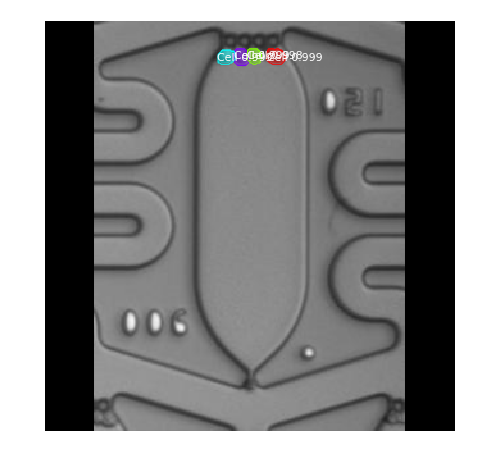

In [238]:
mrcnn_viz.display_instances(
    pred.image, pred.pred_rois, pred.pred_masks, pred.pred_class_ids, 
    dataset_val.class_names, pred.pred_scores, show_bbox=False, figsize=(8, 8))

### External Validation

In [239]:
# External dataset
ext_image_paths = data_files.groupby('group').get_group('external')['image_path'].values
dataset_ext = cell_dataset.CellDataset()
dataset_ext.initialize(ext_image_paths)
dataset_ext.prepare()

In [240]:
pd.set_option('display.max_colwidth', 1000)
df_ext = pd.DataFrame(dict(path=ext_image_paths, idx=np.arange(len(ext_image_paths))))
df_ext[df_ext['path'].str.contains('NoDrug')].head()

,idx,path
14,14,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-z_0-0261-0340-10.jpeg
15,15,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm3-0261-0339-11.jpeg
16,16,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm6-0262-0339-11.jpeg
17,17,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zm9-0262-0339-09.jpeg
18,18,/lab/data/celldom/dataset/dataset03/ApartmentTraining/BF_ST_006_APT_020-NoDrug-02-03-201806041820-zp3-0261-0339-08.jpeg


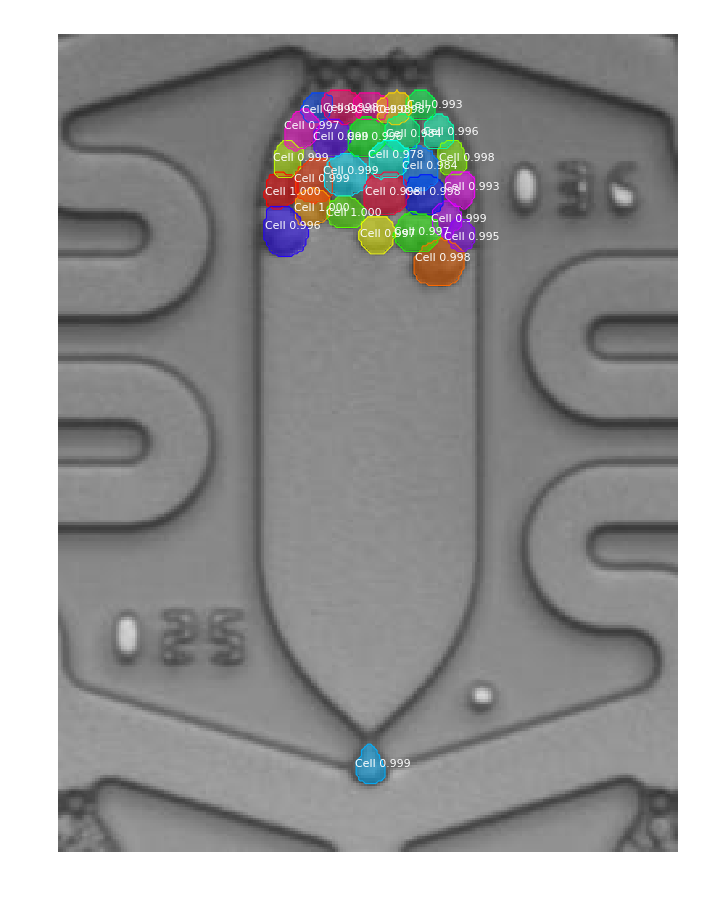

In [273]:
image_id = np.random.choice(dataset_ext.image_ids, size=1)[0]
image = dataset_ext.load_image(image_id)
r = model.detect([image])[0]
mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_ext.class_names, r['scores'], show_bbox=False)